## GAN anomaly 實作 - GANomaly

程式內容包括:
* 建立GANomaly模型架構
* 訓練GANomaly模型
* Anomaly score計算

* 參考資料
[GANomaly] 畫一張一樣照片來做異常檢測
用 Keras 實作 GANomaly - Abby Yeh

https://medium.com/ai-academy-taiwan/d1408cc9b5d0

[github] https://github.com/leafinity/keras_ganomaly/blob/master/ganomaly.ipynb

■ 論文 | GANomaly: Semi-Supervised Anomaly Detection via Adversarial Training, 2018 (https://arxiv.org/abs/1805.06725)

■ 連結 | https://www.paperweekly.site/papers/2293

■ 原始碼 | https://github.com/samet-akcay/ganomaly

杜倫大學提出GANomaly：無需負例樣本實現異常檢測
https://www.mdeditor.tw/pl/2Wrb/zh-tw


Comparison of the three models. A) AnoGAN, B) Efficient-GAN-Anomaly, C) Our Approach: GANomaly
![GANomaly](pic_GANomaly/Comparison-of-the-three-models-A-AnoGAN-39-B-Efficient-GAN-Anomaly-40-C-Our.png)

# Models

Pipeline of the proposed approach for anomaly detection
![GANomaly](pic_GANomaly/Pipeline-of-the-proposed-approach-for-anomaly-detection.png)

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import keras.backend as K
from keras import layers

In [2]:
width = 64
height = 64
channels = 1

## Generators Encoder


In [3]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

# Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

g_e.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
leaky_1 (LeakyReLU)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 128)       73856 

## Generator

In [4]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

x = g_e(input_layer)

y = layers.Dense(width * width * 2, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((width//8, width//8, 128), name='de_reshape')(y)

y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 128)               242048    
_________________________________________________________________
dense (Dense)                (None, 8192)              1056768   
_________________________________________________________________
de_reshape (Reshape)         (None, 8, 8, 128)         0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 16, 16, 128)       147584    
_________________________________________________________________
de_leaky_1 (LeakyReLU)       (None, 16, 16, 128)       0         
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 32, 32, 64)        7379

## Encoder

In [5]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

z = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='encoder_conv_1', kernel_regularizer = 'l2')(input_layer)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='encoder_conv_2', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_1')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='encoder_conv_3', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_2')(z)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_41', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_3')(z)
z = layers.LeakyReLU()(z)

z = layers.GlobalAveragePooling2D(name='encoder_output')(z)

encoder = keras.models.Model(input_layer, z)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 64, 64, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
encoder_norm_1 (BatchNormali (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 16, 16, 128)       7385

## feature extractor

In [6]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='f_conv_1', kernel_regularizer = 'l2')(input_layer)
f = layers.LeakyReLU(name='f_leaky_1')(f)

f = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='f_conv_2', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_1')(f)
f = layers.LeakyReLU(name='f_leaky_2')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_3', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_2')(f)
f = layers.LeakyReLU(name='f_leaky_3')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_4', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_3')(f)
f = layers.LeakyReLU(name='feature_output')(f)

feature_extractor = keras.models.Model(input_layer, f)

feature_extractor.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
f_conv_1 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
f_leaky_1 (LeakyReLU)        (None, 64, 64, 32)        0         
_________________________________________________________________
f_conv_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
f_norm_1 (BatchNormalization (None, 32, 32, 64)        256       
_________________________________________________________________
f_leaky_2 (LeakyReLU)        (None, 32, 32, 64)        0         
_________________________________________________________________
f_conv_3 (Conv2D)            (None, 16, 16, 128)       7385

## gan trainer

![GANomaly](pic_GANomaly/Pipeline-of-the-proposed-approach-for-anomaly-detection.png)

**Contextual Loss**

![GANomaly](pic_GANomaly/contextual_loss.png)

**Adversarial Loss**

![GANomaly](pic_GANomaly/adversarial_loss.png)

**Encoder Loss**

![GANomaly](pic_GANomaly/encoder_loss.png)

**objective function (overall loss)** (w : weighting parameters)

![GANomaly](pic_GANomaly/overall_loss.png)




In [7]:
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
# model for training
input_layer = layers.Input(name='input', shape=(height, width, channels))
gan = g(input_layer) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'adv_loss': 1.0, 'cnt_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)

In [8]:
gan_trainer.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 64, 64, 1)    1538689     input[0][0]                      
__________________________________________________________________________________________________
adv_loss (AdvLoss)              ()                   0           input[0][0]                      
                                                                 model_1[0][0]                    
__________________________________________________________________________________________________
cnt_loss (CntLoss)              ()                   0           input[0][0]                

## discriminator

In [9]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = feature_extractor(input_layer)

d = layers.GlobalAveragePooling2D(name='glb_avg')(f)
d = layers.Dense(1, activation='sigmoid', name='d_out')(d)
    
d = keras.models.Model(input_layer, d)
d.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
model_3 (Functional)         (None, 8, 8, 128)         242048    
_________________________________________________________________
glb_avg (GlobalAveragePoolin (None, 128)               0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 129       
Total params: 242,177
Trainable params: 241,537
Non-trainable params: 640
_________________________________________________________________


In [10]:
d.compile(optimizer='adam', loss='binary_crossentropy')

# Load Data

In [26]:
from tensorflow.keras.datasets import mnist
# Get the working directory path
import os
current_dir = os.getcwd()

# Import mnist data stored in the following path: current directory -> /datasets/MNIST/mnist.npz
(x_train, y_train), (x_test, y_test) = mnist.load_data(path=current_dir+'/datasets/MNIST/mnist.npz')

In [27]:
import cv2
import numpy as np

x_ok = x_train[y_train == 1] # 6742 筆
x_test = x_test[(y_test == 7) | (y_test == 1)] # 1135 筆 "1", 1028 筆 "7"
y_test = y_test[(y_test == 7) | (y_test == 1)]

def reshape_x(x):
    new_x = np.empty((len(x), width, height))
    for i, e in enumerate(x):
        new_x[i] = cv2.resize(e, (width, height))
    return np.expand_dims(new_x, axis=-1) / 127 - 1
  
x_ok = reshape_x(x_ok)
x_test = reshape_x(x_test)

In [28]:
x_ok.max()

1.0078740157480315

# Training

In [13]:
niter = 400
bz = 256

In [14]:
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]

In [15]:
train_data_generator = get_data_generator(x_ok, bz)

In [16]:
his_g_loss = []
his_adv_loss = []
his_cnt_loss = []
his_enc_loss = []
his_d_loss = []

for i in range(niter):
    
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
        
    ### train disciminator ###
    d.trainable = True
        
    fake_x = g.predict(x)
        
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
        
    d_loss = d.train_on_batch(d_x, d_y)

    ### train generator ###
    
    d.trainable = False
    g_loss = gan_trainer.train_on_batch(x, y)

    #記錄training loss
    his_g_loss.append(g_loss[0])
    his_adv_loss.append(g_loss[1])
    his_cnt_loss.append(g_loss[2])
    his_enc_loss.append(g_loss[3])
    his_d_loss.append(d_loss)

    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

    # early-stop:
    if g_loss[0]<=0.1 or d_loss<=0.05:
        print(f'niter: {i+1}, ** early-stop ** g_loss: {g_loss}, d_loss: {d_loss}')
        break

niter: 1, g_loss: [6.11863374710083, 0.003434328828006983, 0.9517908096313477, 0.00818325113505125], d_loss: 3.140575885772705
niter: 51, g_loss: [0.4006521701812744, 0.0001936481276061386, 0.12067210674285889, 0.0006402250146493316], d_loss: 0.941010594367981
niter: 101, g_loss: [0.18356716632843018, 5.2826321734755766e-06, 0.12214398384094238, 0.0011277582962065935], d_loss: 0.35789963603019714
niter: 151, g_loss: [0.16616509854793549, 5.817230999127787e-07, 0.11981348693370819, 0.0006711839232593775], d_loss: 0.16018326580524445
niter: 201, g_loss: [0.16101257503032684, 1.4025448535903706e-07, 0.11893178522586823, 0.0008528229664079845], d_loss: 0.07968685775995255
niter: 239, ** early-stop ** g_loss: [0.15706230700016022, 1.5015797316664248e-07, 0.11561152338981628, 0.0029711341485381126], d_loss: 0.04979601502418518


In [17]:
len(his_g_loss)

239

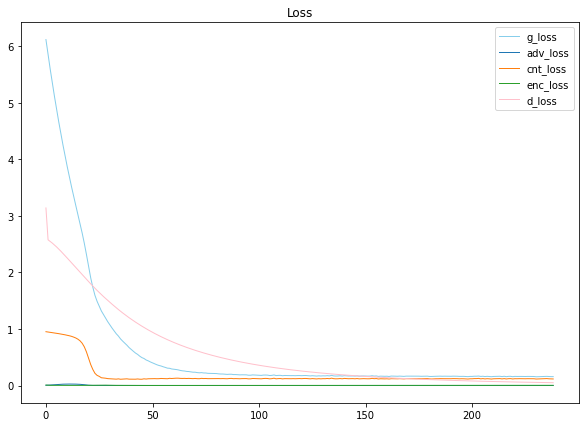

In [18]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 10, 7

''' Visualize the loss and accuracy of both models'''
plt.figure(0)

x_step = np.arange(len(his_g_loss))

plt.plot( x_step, his_g_loss, marker='', color='skyblue', linewidth=1, label="g_loss")
plt.plot( x_step, his_adv_loss, marker='', linewidth=1, label="adv_loss")
plt.plot( x_step, his_cnt_loss, marker='', linewidth=1, label="cnt_loss")
plt.plot( x_step, his_enc_loss, marker='', linewidth=1, label="enc_loss")
plt.plot( x_step, his_d_loss, marker='', color='pink', linewidth=1, label="d_loss")

plt.title('Loss')
plt.legend(loc='upper right')

plt.show()

# Evaluation

![GANomaly](pic_GANomaly/scoring.png)

***anomaly scores*** (如同encoder loss計算, 但只取差距總合絶對值, input image= x_hat(即上圖x'))

![GANomaly](pic_GANomaly/anomaly_score.png)

***anomaly scores within the probabilistic*** range of [0; 1]

**normal** -> 0, and **abnormal** -> 1

![GANomaly](pic_GANomaly/anomaly_score_within_probabilistic_range.png)

In [19]:
encoded = g_e.predict(x_test)

gan_x = g.predict(x_test)
encoded_gan = encoder.predict(gan_x)

A_score = np.sum(np.absolute(encoded - encoded_gan), axis=-1) #axis=-1:sum by column
P_score = (A_score - np.min(A_score)) / (np.max(A_score) - np.min(A_score)) # map to 0~1

In [20]:
gan_x.shape, encoded.shape, encoded_gan.shape

((2163, 64, 64, 1), (2163, 128), (2163, 128))

In [21]:
#取某一筆出來計算 A_Score
np.sum(np.absolute(encoded[0] - encoded_gan[0]))

21.992132

In [22]:
P_score.shape

(2163,)

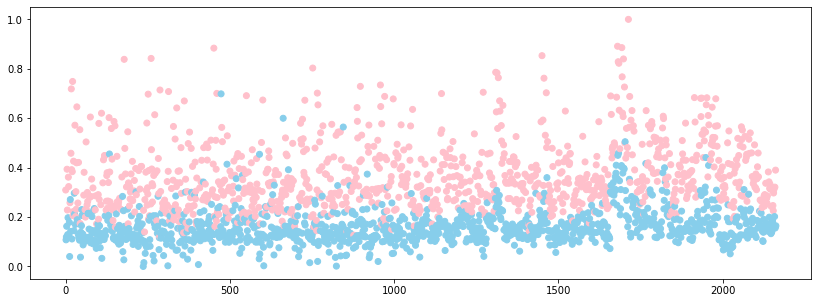

In [23]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(x_test)), P_score, c=['skyblue' if x == 1 else 'pink' for x in y_test])
# x==1:數字1為normal(藍色), 其它為abnormal(紅色)

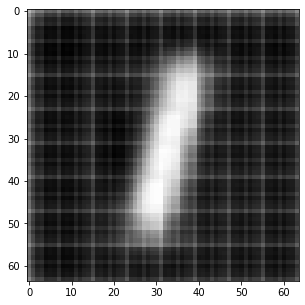

In [24]:
i = 4 # or 1
image = np.reshape(gan_x[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

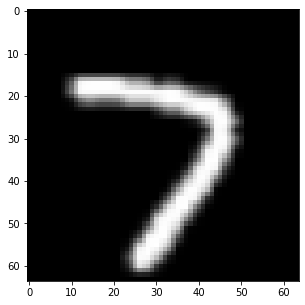

In [25]:
image = np.reshape(x_test[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

----